# POS-тэггинг с CRFSuite

Елена Сокур (152), Анна Зуева (151).

CRFSuite — одна из нескольких систем для последовательного теггинга, основанных на CRF. В питоне есть две обёртки: `pycrfsuite` и `sklearn_crfsuite`.

Корпус: фрагмент НКРЯ в 1 млн словоупотреблений.

In [1]:
import pycrfsuite

In [2]:
import codecs

## 1 Загрузка корпуса

In [3]:
def read_ruscorpora(filename):
    sent = [[]]
    with codecs.open(filename) as inp_file:
        for line in inp_file:
            line = line.strip('\r\n ')
            if '\t' in line:
                line = line[:line.find('\t')]
            if line.startswith('#'):
                continue
            if not line:
                sent.append([])
                continue
            wordform, lemma, gram = line.rsplit('/', 2)
            pos = gram[:gram.find('=')] if '=' in gram else gram
            pos = pos.split(',')[0]
            sent[-1].append((wordform, pos, lemma, gram))
    
    return sent

In [4]:
corpus = read_ruscorpora('ruscorpora.parsed.txt')

In [5]:
for word in corpus[0]:
    print(word[0], word[1], word[2], word[3])

Якутское A якутский A=n,sg,nom,plen
отделение S отделение S,n,inan=sg,nom
Единой A единый A=f,sg,gen,plen
России S Россия S,f,inan=sg,gen
планирует V планировать V,ipf,tran=sg,act,praes,3p,indic
создать V создать V,pf,tran=inf,act
комитеты S комитет S,m,inan=pl,acc
партийного A партийный A=m,sg,gen,plen
контроля S контроль S,m,inan=sg,gen
наподобие PR наподобие PR
существовавших V существовать V,ipf,intr,act=partcp,pl,gen,praet,plen
в PR в PR
СССР S СССР S,m,inan,0=sg,loc
на PR на PR
базе S база S,f,inan=sg,loc
КПСС S КПСС S,f,inan,0=sg,gen


## 2 Преобразование текста в фичи

Для каждого токена в качестве признаков мы будем использовать само слово и его контекст — несколько слов слева и справа. Количество контекста передается в аргументе `n_context`.

Если достаточного количества слов слева нет, то добавляется специальный признак начала предложения: `BOS`. Если нет контекста справа, то признак конца предложения: `EOS`.

In [6]:
def word2features(sent, i, n_context):
    word = sent[i][0]

    features = [
        'word=' + word
    ]
    
    for i_context in range(i-n_context, i):
        if i_context >= 0:
            features.extend([
                    '-{}:word='.format(i_context) + sent[i_context][0]
                ])
        else:
            features.append('BOS')
    for i_context in range(i+1, i+1+n_context):
        if i_context < len(sent):
            features.extend([
                    '+{}:word='.format(i_context) + sent[i_context][0]
                ])
        else:
            features.append('EOS')
    
    return features

Вспомогательные функции для преобразования предложения в последовательность признаков и тегов.

In [5]:
def sent2features(sent, n_context):
    return [word2features(sent, i, n_context) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for token, postag, lemma, gram in sent]

def sent2tokens(sent):
    return [token for token, postag, lemma, gram in sent]

Разобьем корпус на тестовую и тренировочную выборку случайным образом.

In [7]:
%%time
from sklearn.model_selection import train_test_split

n_context = 2

X_2 = [sent2features(s, n_context) for s in corpus]
y_2 = [sent2labels(s) for s in corpus]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

CPU times: user 9.25 s, sys: 1.06 s, total: 10.3 s
Wall time: 10.4 s


In [7]:
%%time
from sklearn.model_selection import train_test_split

n_context = 3

X_3 = [sent2features(s, n_context) for s in corpus]
y_3 = [sent2labels(s) for s in corpus]
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=42)

CPU times: user 8.14 s, sys: 427 ms, total: 8.57 s
Wall time: 8.74 s


In [8]:
%%time
from sklearn.model_selection import train_test_split

n_context = 4

X_4 = [sent2features(s, n_context) for s in corpus]
y_4 = [sent2labels(s) for s in corpus]
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.3, random_state=42)

CPU times: user 7.84 s, sys: 311 ms, total: 8.15 s
Wall time: 8.54 s


## 3 Обучение
## 3.1 Baseline

In [9]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
# вспомогательная функция для тренировок
def get_class_report(params, X_train, y_train, X_test, y_test):
    
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)
        
    trainer.set_params(params)
    
    print('Training...')
    trainer.train('ruscorpora.crfsuite')
    !ls -lh ./ruscorpora.crfsuite
    print('Saved.')
    
    tagger = pycrfsuite.Tagger()
    tagger.open('ruscorpora.crfsuite')

    y_pred = [tagger.tag(xseq) for xseq in X_test]
    binizer = MultiLabelBinarizer(classes=['A', 'A-PRO', 'ADV', 'ADV-PRO', 'ANUM', 'CONJ', 
                                           'INIT', 'INTJ', 'NONLEX', 'NUM', 'PARENTH', 'PART', 
                                           'PR', 'PRAEDIC', 'PRAEDIC-PRO', 'S', 'S-PRO', 'V'])
    y_pred_bin = binizer.fit_transform(y_pred)
    y_test_bin = binizer.transform(y_test)
    print('Classification report:')
    print(classification_report(y_test_bin, y_pred_bin))
    print('Accuracy score: {}'.format(metrics.accuracy_score(y_test_bin, y_pred_bin)))

In [10]:
# baseline params
params = {
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 50,  # stop earlier

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
}

In [18]:
# первая тренировка: baseline params, n_context = 2
get_class_report(params, X_train_2, y_train_2, X_test_2, y_test_2)

Classification report:
             precision    recall  f1-score   support

          0       0.86      0.91      0.88     12313
          1       0.96      0.96      0.96      8972
          2       0.94      0.90      0.92      8040
          3       0.95      0.91      0.93      5237
          4       0.92      0.73      0.82      1200
          5       0.97      0.98      0.97     12564
          6       0.93      0.89      0.91       721
          7       0.91      0.67      0.77       246
          8       0.96      0.65      0.78       855
          9       0.97      0.95      0.96      5297
         10       0.87      0.85      0.86      1418
         11       0.96      0.94      0.95      8709
         12       0.99      1.00      1.00     14520
         13       0.85      0.79      0.82      2101
         14       0.88      1.00      0.94        15
         15       0.96      0.99      0.98     21231
         16       0.96      0.97      0.97     12337
         17       0.97

Мы можем заметить, что самое плохое качество достигается на наименее важных категориях: `NONLEX`, `INTJ` и `PARENTH`. То есть на важных грамматических категориях качество на самом деле выше.

In [44]:
for indx, part in enumerate(binizer.classes_):
    print(indx, part)

0 A
1 A-PRO
2 ADV
3 ADV-PRO
4 ANUM
5 CONJ
6 INIT
7 INTJ
8 NONLEX
9 NUM
10 PARENTH
11 PART
12 PR
13 PRAEDIC
14 PRAEDIC-PRO
15 S
16 S-PRO
17 V


## 3.2 Расширение контекста

In [20]:
# попробуем увеличить контекст до 3
get_class_report(params, X_train_3, y_train_3, X_test_3, y_test_3)

Training...
-rw-rw-r-- 1 socur socur 6,7M июн 17 22:59 ./ruscorpora.crfsuite
Saved.
Classification report:
             precision    recall  f1-score   support

          0       0.87      0.90      0.88     12313
          1       0.96      0.96      0.96      8972
          2       0.94      0.90      0.92      8040
          3       0.95      0.91      0.93      5237
          4       0.93      0.72      0.81      1200
          5       0.97      0.98      0.97     12564
          6       0.92      0.90      0.91       721
          7       0.90      0.66      0.76       246
          8       0.95      0.65      0.77       855
          9       0.97      0.95      0.96      5297
         10       0.87      0.84      0.86      1418
         11       0.96      0.94      0.95      8709
         12       0.99      1.00      1.00     14520
         13       0.86      0.79      0.82      2101
         14       0.94      1.00      0.97        15
         15       0.97      0.99      0.98  

In [21]:
# попробуем увеличить контекст до 4
get_class_report(params, X_train_4, y_train_4, X_test_4, y_test_4)

Training...
-rw-rw-r-- 1 socur socur 11M июн 17 23:01 ./ruscorpora.crfsuite
Saved.
Classification report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88     12313
          1       0.96      0.96      0.96      8972
          2       0.94      0.90      0.92      8040
          3       0.95      0.91      0.93      5237
          4       0.93      0.72      0.81      1200
          5       0.97      0.98      0.97     12564
          6       0.93      0.87      0.90       721
          7       0.91      0.67      0.77       246
          8       0.97      0.62      0.76       855
          9       0.97      0.95      0.96      5297
         10       0.87      0.83      0.85      1418
         11       0.96      0.94      0.95      8709
         12       1.00      1.00      1.00     14520
         13       0.85      0.79      0.82      2101
         14       0.88      1.00      0.94        15
         15       0.96      0.99      0.98   

Как видно, расширение контекста приводит к падению accuracy. 

## 3.3 Подбор гиперпараметров для crfsuite

In [22]:
# попробуем немного изменить параметры c2 и max_iterations
params_c2 = {
    'c1': 1.0,   
    'c2': 1.0, 
    'max_iterations': 100,  
    'feature.possible_transitions': True
}

In [27]:
# с2=1.0, max_iterations=100, n_context = 2
get_class_report(params_c2, X_train_2, y_train_2, X_test_2, y_test_2)

Training...
-rw-rw-r-- 1 socur socur 6,4M июн 17 23:11 ./ruscorpora.crfsuite
Saved.
Classification report:
             precision    recall  f1-score   support

          0       0.82      0.88      0.85     12313
          1       0.95      0.94      0.95      8972
          2       0.94      0.83      0.88      8040
          3       0.96      0.89      0.92      5237
          4       0.96      0.56      0.71      1200
          5       0.96      0.98      0.97     12564
          6       0.94      0.84      0.89       721
          7       0.93      0.39      0.55       246
          8       0.84      0.49      0.62       855
          9       0.97      0.90      0.93      5297
         10       0.89      0.77      0.82      1418
         11       0.97      0.93      0.95      8709
         12       0.99      1.00      0.99     14520
         13       0.88      0.73      0.80      2101
         14       1.00      0.60      0.75        15
         15       0.95      0.99      0.97  

In [29]:
# уменьшим c1 и c2
params_c = {    
    'c1': 0.1,
    'c2': 0.1,
    'max_iterations': 100,
    'feature.possible_transitions': True
}

In [30]:
# c1=0.1, с2=0.1, max_iterations=100, n_context = 2
get_class_report(params_c, X_train_2, y_train_2, X_test_2, y_test_2)

Training...
-rw-rw-r-- 1 socur socur 36M июн 17 23:15 ./ruscorpora.crfsuite
Saved.
Classification report:
             precision    recall  f1-score   support

          0       0.88      0.91      0.90     12313
          1       0.96      0.96      0.96      8972
          2       0.94      0.89      0.92      8040
          3       0.96      0.91      0.93      5237
          4       0.94      0.69      0.79      1200
          5       0.97      0.98      0.97     12564
          6       0.93      0.88      0.91       721
          7       0.95      0.63      0.76       246
          8       0.98      0.61      0.75       855
          9       0.97      0.95      0.96      5297
         10       0.89      0.82      0.85      1418
         11       0.96      0.94      0.95      8709
         12       1.00      1.00      1.00     14520
         13       0.87      0.78      0.82      2101
         14       0.93      0.93      0.93        15
         15       0.97      0.99      0.98   

Первое улучшение получено: accuracy увеличилось на 2%, precision на 1%.

## 3.4 Обёртка sklearn_crfsuite.CRF

Тут мы пытались использовать другую обёртку для того, чтобы можно было прогнаться по GridSearchCV, но не получилось :( 

In [31]:
import sklearn_crfsuite

In [33]:
%%time

# c1=0.1, с2=0.1, max_iterations=100, n_context = 2

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train_2, y_train_2)

CPU times: user 3min 12s, sys: 388 ms, total: 3min 12s
Wall time: 3min 12s


In [35]:
y_pred = crf.predict(X_test_2)

binizer = MultiLabelBinarizer(classes=['A', 'A-PRO', 'ADV', 'ADV-PRO', 'ANUM', 'CONJ', 
                                           'INIT', 'INTJ', 'NONLEX', 'NUM', 'PARENTH', 'PART', 
                                           'PR', 'PRAEDIC', 'PRAEDIC-PRO', 'S', 'S-PRO', 'V'])
y_pred_bin = binizer.fit_transform(y_pred)
y_test_bin = binizer.transform(y_test_2)
print(classification_report(y_test_bin, y_pred_bin))
print('Accuracy score: {}'.format(metrics.accuracy_score(y_test_bin, y_pred_bin)))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90     12313
          1       0.96      0.96      0.96      8972
          2       0.94      0.89      0.92      8040
          3       0.96      0.91      0.93      5237
          4       0.94      0.69      0.79      1200
          5       0.97      0.98      0.97     12564
          6       0.93      0.88      0.91       721
          7       0.95      0.63      0.76       246
          8       0.98      0.61      0.75       855
          9       0.97      0.95      0.96      5297
         10       0.89      0.82      0.85      1418
         11       0.96      0.94      0.95      8709
         12       1.00      1.00      1.00     14520
         13       0.87      0.78      0.82      2101
         14       0.93      0.93      0.93        15
         15       0.97      0.99      0.98     21231
         16       0.96      0.97      0.97     12337
         17       0.98      0.96      0.97   

In [14]:
import numpy as np

In [15]:
import scipy
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [37]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params = {
    'c1': np.logspace(-1, 2, 3),
    'c2': np.logspace(-1, 2, 3),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.f1_score,
                         average='weighted')

# search
rs = GridSearchCV(crf, params,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        scoring=f1_scorer)
rs.fit(X_train_2, y_train_2)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/socur/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/socur/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/home/socur/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 20, in __ini

AttributeError: 'NoneType' object has no attribute 'terminate'

## 4 Evaluation

Ещё раз натренируем лучший тэггер.

In [39]:
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train_2, y_train_2):
    trainer.append(xseq, yseq)
        
trainer.set_params(params_c)
    
print('Training...')
trainer.train('ruscorpora.crfsuite')
!ls -lh ./ruscorpora.crfsuite
print('Saved.')

Training...
-rw-rw-r-- 1 socur socur 36M июн 17 23:30 ./ruscorpora.crfsuite
Saved.


In [10]:
tagger = pycrfsuite.Tagger()
tagger.open('ruscorpora.crfsuite')

y_pred = [tagger.tag(xseq) for xseq in X_test_2]
binizer = MultiLabelBinarizer(classes=['A', 'A-PRO', 'ADV', 'ADV-PRO', 'ANUM', 'CONJ', 
                                           'INIT', 'INTJ', 'NONLEX', 'NUM', 'PARENTH', 'PART', 
                                           'PR', 'PRAEDIC', 'PRAEDIC-PRO', 'S', 'S-PRO', 'V'])

In [19]:
y_pred_bin = binizer.fit_transform(y_pred)
y_test_bin = binizer.transform(y_test_2)

In [52]:
binizer.classes_

array(['A', 'A-PRO', 'ADV', 'ADV-PRO', 'ANUM', 'CONJ', 'INIT', 'INTJ',
       'NONLEX', 'NUM', 'PARENTH', 'PART', 'PR', 'PRAEDIC', 'PRAEDIC-PRO',
       'S', 'S-PRO', 'V'], dtype=object)

In [41]:
labels = ['A', 'A-PRO', 'ADV', 'ADV-PRO', 'ANUM', 'CONJ', 
                    'INIT', 'INTJ', 'NONLEX', 'NUM', 'PARENTH', 'PART', 
                    'PR', 'PRAEDIC', 'PRAEDIC-PRO', 'S', 'S-PRO', 'V']

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics import confusion_matrix

In [68]:
print(confusion_matrix([lab for sent in y_test_2 for lab in sent], [lab for sent in y_pred for lab in sent], 
                       labels=labels))

[[21220     4   254     2     0     0     1     0    22    27    16    21
      2    98     0  4081     0  1328]
 [   78 13113     0     0    31    12     0     0     1     2     0    13
      2     0     0    88   569    26]
 [  385    28  9634    20     0    30     0     0     4    46    49    68
     55    66     0   551   135   312]
 [   20     2    47  5796     0   513     0     0     0    63     3     9
      0     5     0    45    61    17]
 [   72   211     0     0   909     0     0     0     7     9     0     0
      0     0     0   154     0    36]
 [    4     5    46   152     0 21478     2     0     0     0     0   413
      0     0     0    28   206     8]
 [    3     0     0     0     0    32  1021     0     3     0     0     0
     55     0     0    32     3     3]
 [   15     0     3     0     0     8     5   166     0     0     0     0
      7     0     0    55     0    19]
 [  228    10     0     0     8     7     6     0  1743     5     0     5
     12     0     0   

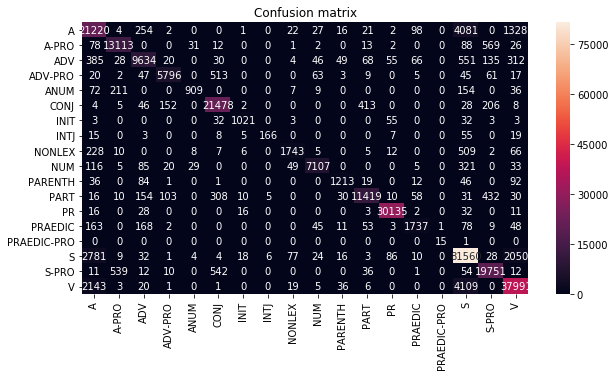

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix([lab for sent in y_test_2 for lab in sent], [lab for sent in y_pred for lab in sent],
                                  labels=binizer.classes_), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

In [33]:
from nltk.tokenize import word_tokenize

In [34]:
from string import punctuation, digits
punctuation = set(punctuation + '«»—–…“”\\n\\t№' + digits) - set('-')
table = str.maketrans({ch: ' ' for ch in punctuation})

In [35]:
sent = u'Хорошо, когда на улице солнце'
tagger.tag(sent2features([[item] for item in word_tokenize(sent.translate(table))], 2))

['PART', 'CONJ', 'PR', 'S', 'S']

In [ ]:
with open('test.txt', 'r', encoding='utf-8') as f:
    with open('output', 'a', encoding='utf-8') as fw:
        text = f.read()
        text = text.translate(table)
        res = tagger.tag(sent2features([[item] for item in word_tokenize(text)], 2))
        for elem1, elem2 in zip(word_tokenize(text), res):
            fw.write(elem1 + '\t' + elem2 + '\n')